In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [11]:
seed <- 221

set.seed(seed)
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) %>%
    rename("age" = X1,
          "sex" = X2,
          "cp" = X3, 
          "trestbps" = X4,
          "chol" = X5, 
          "fbs" = X6,
          "restecg" = X7, 
          "thalach" = X8,
          "exang" = X9,
          "oldpeak" = X10,
          "slope" = X11,
          "ca" = X12,
          "thal" = X13,
          "num" = X14) %>%
    mutate(ca = as.double(ca), thal = as.double(thal), sex = as_factor(sex), num = as_factor(num), cp = as_factor(cp), fbs = as_factor(fbs), restecg = as_factor(restecg), exang = as_factor(exang), slope = as_factor(slope), ca = as.integer(ca), thal = as_factor(thal)) %>%
    mutate(hasdisease = as_factor(num != 0)) %>%
    na.omit()

heart_disease_split <- initial_split(cleveland_data, prop = 0.75, strata = hasdisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)
cleveland_data %>% head(15)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.double(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.double(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hasdisease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,FALSE
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3,TRUE
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0,FALSE
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2,TRUE


In [ ]:
set.seed(seed)

vfold <- vfold_cv(heart_disease_train, v = 5, strata = hasdisease)

heart_disease_recipe <- recipe(hasdisease ~ age + thalach, data = heart_disease_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_results <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 5))) %>%
    collect_metrics()

accuracies <- knn_results %>%
    filter(.metric == "accuracy")
accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k


In [52]:
set.seed(seed)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = heart_disease_train)

heart_disease_test_predictions <- predict(knn_fit, heart_disease_test) %>%
    bind_cols(heart_disease_test)

heart_disease_test_accuracy <- heart_disease_test_predictions %>%
    metrics(truth = hasdisease, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
heart_disease_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7702703


          Truth
Prediction FALSE TRUE
     FALSE    33   10
     TRUE      7   24

Type,Value,Prediction
<chr>,<dbl>,<chr>
True positive,24,Correct
True negative,33,Correct
False positive,7,Incorrect
False negative,10,Incorrect


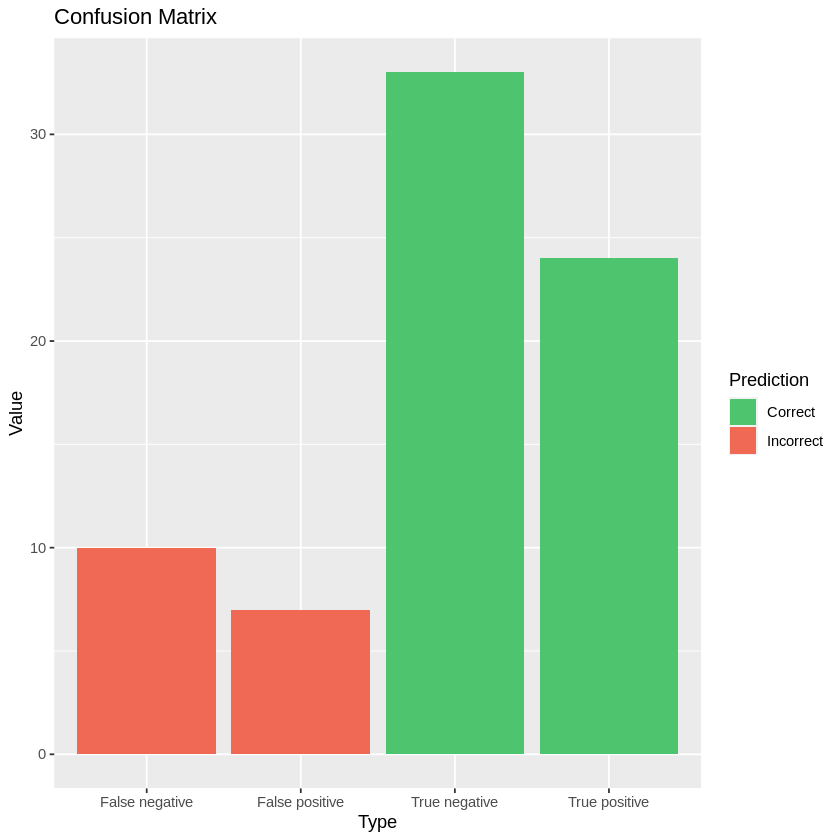

In [94]:
heart_disease_test_predictions %>% 
    conf_mat(truth = hasdisease, estimate = .pred_class)


new_tibble<-tibble(c("True positive","True negative","False positive","False negative"),c(24,33,7,10),c("Correct","Correct","Incorrect","Incorrect"))
colnames(new_tibble) <- c("Type","Value","Prediction")
new_tibble
plot<-ggplot(new_tibble, aes(x=Type ,y=Value,fill=Prediction)) +
     geom_bar(stat="identity")+
     labs(x="Type",y="Value",fill="Prediction") +
    scale_fill_manual(values=c("#4dc46d","#f06954"))+
    ggtitle("Confusion Matrix")

plot

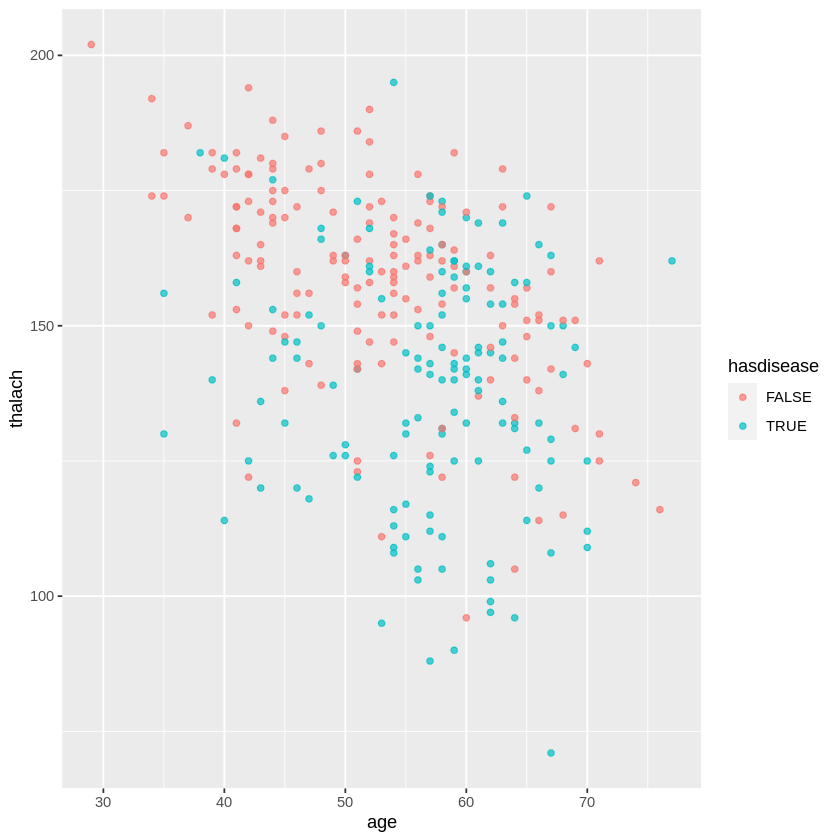

In [21]:
scatterplot <- cleveland_data %>%
    ggplot(aes(x = age, y = thalach, colour = hasdisease)) +
    geom_point(alpha = 0.7)
scatterplot